In [1]:
import datetime as dt
from datetime import date
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import pyproj
from shapely.ops import transform
import networkx as nx

/home/twenty/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
routes = pd.read_csv('data/india/GTFS/routes.txt')

# Number of routes

In [3]:
routes.route_long_name.unique().shape

(1270,)

In [34]:
# Number of routes per km2
1270 / 1484

0.8557951482479784

In [35]:
# Number of routes per capita
1270 / 16_787_941

7.564953915432511e-05

# Number of stops

In [4]:
stops = pd.read_csv('data/india/GTFS/stops.txt')

In [5]:
stops.stop_id.unique().shape

(4192,)

In [36]:
# Number of stops per km2
4192 / 1484

2.824797843665768

In [37]:
# Number of stops per capita
4192 / 16_787_941

0.00024970304577553613

# Average number of stops per route

Should we make a distinction between route and trip? What if a route has two different trips that goes to a different set of stations? Why should we treat them a single route, rather than two separate routes?

If we ignore routes and only count trips, the calculation becomes much easier

In [6]:
trips = pd.read_csv('data/india/GTFS/trips.txt')

In [7]:
stop_times = pd.read_csv('data/india/GTFS/stop_times.txt')

In [8]:
trip_to_stop_id = stop_times[['trip_id', 'stop_id']].drop_duplicates()
trip_to_stop_id

,trip_id,stop_id
0,1_07_00,23
1,1_07_00,24
2,1_07_00,25
3,1_07_00,26
4,1_07_00,27
...,...,...
2250285,1268_21_30,371
2250286,1268_21_30,372
2250287,1268_21_30,1736
2250288,1268_21_30,1738


In [9]:
num_stops_in_every_trip = trip_to_stop_id.groupby('trip_id').stop_id.count()
num_stops_in_every_trip

trip_id
0_20_20    20
0_20_30    20
0_20_40    20
0_20_50    20
0_21_00    20
           ..
9_21_10    40
9_21_20    40
9_21_30    40
9_21_40    40
9_21_50    40
Name: stop_id, Length: 50355, dtype: int64

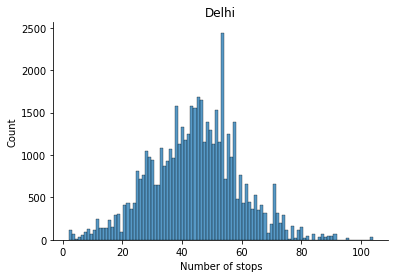

In [22]:
sns.histplot(x=num_stops_in_every_trip)
plt.xlabel('Number of stops')
plt.title('Delhi')
sns.despine()
plt.savefig('figures/d_nstops.png')

In [11]:
num_stops_in_every_trip.mean()

44.412848773706685

In [12]:
num_stops_in_every_trip.median()

45.0

# Average route length

Again, we're going to consider each trip as a route by themselves

In [13]:
# wgs84 is in degrees, pseudo mercator is in meters
wgs84 = pyproj.CRS('EPSG:4326')
pseudo_mercator = pyproj.CRS('EPSG:3857')
project = pyproj.Transformer.from_crs(wgs84, pseudo_mercator, always_xy=True).transform

def transformer(p: Point):
    return transform(project, p)

Need to use the stop_sequence to ensure the stops are in order

In [14]:
stop_times_with_loc = stop_times.merge(stops, on='stop_id')
stop_times_with_loc

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_code,stop_name,stop_lat,stop_lon,zone_id
0,1_07_00,07:00:00,07:00:00,23,0,DC3605,Swaroop Nagar GT Road,28.758318,77.148305,23
1,1_07_10,07:10:00,07:10:00,23,0,DC3605,Swaroop Nagar GT Road,28.758318,77.148305,23
2,1_07_20,07:20:00,07:20:00,23,0,DC3605,Swaroop Nagar GT Road,28.758318,77.148305,23
3,1_07_30,07:30:00,07:30:00,23,0,DC3605,Swaroop Nagar GT Road,28.758318,77.148305,23
4,1_07_40,07:40:00,07:40:00,23,0,DC3605,Swaroop Nagar GT Road,28.758318,77.148305,23
...,...,...,...,...,...,...,...,...,...,...
2250285,1254_20_30,21:47:58,21:47:58,4033,37,DC5349,Alok Kunj,28.727686,77.130562,4033
2250286,1254_20_40,21:57:58,21:57:58,4033,37,DC5349,Alok Kunj,28.727686,77.130562,4033
2250287,1254_21_10,22:27:58,22:27:58,4033,37,DC5349,Alok Kunj,28.727686,77.130562,4033
2250288,1254_21_20,22:37:58,22:37:58,4033,37,DC5349,Alok Kunj,28.727686,77.130562,4033


I can't find the code for this one

but 175STLDOWN and 133DOWN shares the first half - then continues after the last stop

https://www.transsee.ca/stoplist?a=delhi&r=1102

https://www.transsee.ca/stoplist?a=delhi&r=1230

In [15]:
stop_times_with_loc[stop_times_with_loc.trip_id == '0_20_20'].sort_values('stop_sequence')

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_code,stop_name,stop_lat,stop_lon,zone_id
1028702,0_20_20,20:20:00,20:20:00,3,0,DC4542,Ramdev Chowk Pithori Jhori,28.857752,77.092856,3
1030702,0_20_20,20:21:08,20:21:08,4,1,DC4543,Narela A-6 / CPJ College,28.857652,77.095746,4
918200,0_20_20,20:22:02,20:22:02,5,2,DC4544,State Bank Of Allahbad,28.857128,77.097951,5
919841,0_20_20,20:23:10,20:23:10,6,3,DC4545,Sec A-9 Narela,28.854546,77.097907,6
921482,0_20_20,20:24:24,20:24:24,7,4,DC4546,Sec A-9 and A-6 Narela,28.851771,77.097849,7
923123,0_20_20,20:25:38,20:25:38,8,5,DC4547,A-7 Narela Sec- 10A Pocket- 66,28.849048,77.098446,8
924764,0_20_20,20:29:33,20:29:33,9,6,DC4548,Harish Chandra Hospital,28.840806,77.102022,9
926276,0_20_20,20:31:44,20:31:44,10,7,DC4549,Kasturi Ram School,28.837182,77.098223,10
927898,0_20_20,20:34:10,20:34:10,11,8,DC4550,Munim Ji Ka Bagh,28.836163,77.092108,11
929341,0_20_20,20:35:10,20:35:10,12,9,DC4551,New Anaj Mandi,28.838335,77.091413,12


In [16]:
trips[trips.trip_id == '0_20_20']

,route_id,service_id,trip_id,shape_id
0,0,1,0_20_20,NaN


In [17]:
routes[routes.route_id == 0]

,route_short_name,route_long_name,route_type,route_id,agency_id
0,NaN,193STLDOWN,3,0,DIMTS


In [18]:
def f(x):
    df = x.sort_values('stop_sequence')
    points = df[['stop_lon', 'stop_lat']].apply(
        lambda row: transformer(Point(row.stop_lon, row.stop_lat)),
        axis=1
    )
    return LineString(points.reset_index(drop=True))

trip_lines = stop_times_with_loc.groupby('trip_id').apply(f)
trip_lines

trip_id
0_20_20    LINESTRING (8581937.473719167 3357553.47980293...
0_20_30    LINESTRING (8581937.473719167 3357553.47980293...
0_20_40    LINESTRING (8581937.473719167 3357553.47980293...
0_20_50    LINESTRING (8581937.473719167 3357553.47980293...
0_21_00    LINESTRING (8581937.473719167 3357553.47980293...
                                 ...                        
9_21_10    LINESTRING (8591437.033785501 3338474.19579364...
9_21_20    LINESTRING (8591437.033785501 3338474.19579364...
9_21_30    LINESTRING (8591437.033785501 3338474.19579364...
9_21_40    LINESTRING (8591437.033785501 3338474.19579364...
9_21_50    LINESTRING (8591437.033785501 3338474.19579364...
Length: 50355, dtype: object

In [19]:
trip_lengths = trip_lines.apply(lambda x: x.length)
trip_lengths

trip_id
0_20_20    12877.486982
0_20_30    12877.486982
0_20_40    12877.486982
0_20_50    12877.486982
0_21_00    12877.486982
               ...     
9_21_10    26993.556533
9_21_20    26993.556533
9_21_30    26993.556533
9_21_40    26993.556533
9_21_50    26993.556533
Length: 50355, dtype: float64

In [20]:
# Average trip length in meters
trip_lengths.mean()

26952.221183462545

In [21]:
trip_lengths.median()

26043.582617595206

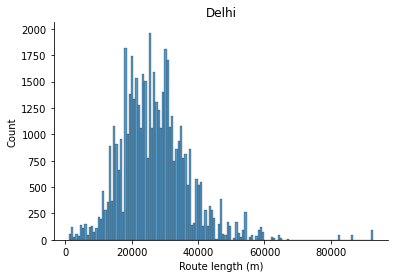

In [23]:
sns.histplot(x=trip_lengths)
sns.despine()
plt.title('Delhi')
plt.xlabel('Route length (m)')
plt.savefig('figures/d_rlengths.png')

In [24]:
trip_lengths.sort_values(ascending=False).head()

trip_id
261_10_40    92735.71019
261_18_20    92735.71019
261_18_00    92735.71019
261_17_50    92735.71019
261_17_40    92735.71019
dtype: float64

# Average distance between stops

In [25]:
def calc_distances(x):
    '''
    input: [(float, float)]
        a list of coordinates
    output: [float]
        the distances between each coordinates
    '''
    return [Point(a).distance(Point(b)) for a, b in zip(x, x[1:])]

In [26]:
def f(x):
    df = x.sort_values('stop_sequence')
    points = df[['stop_lon', 'stop_lat']].apply(
        lambda row: transformer(Point(row.stop_lon, row.stop_lat)),
        axis=1
    )
    return calc_distances(points.reset_index(drop=True))

trip_stop_dists = stop_times_with_loc.groupby('trip_id').apply(f)
trip_stop_dists

trip_id
0_20_20    [321.9643107629447, 254.33472327080472, 328.21...
0_20_30    [321.9643107629447, 254.33472327080472, 328.21...
0_20_40    [321.9643107629447, 254.33472327080472, 328.21...
0_20_50    [321.9643107629447, 254.33472327080472, 328.21...
0_21_00    [321.9643107629447, 254.33472327080472, 328.21...
                                 ...                        
9_21_10    [1026.7149419510426, 313.99021599772726, 716.3...
9_21_20    [1026.7149419510426, 313.99021599772726, 716.3...
9_21_30    [1026.7149419510426, 313.99021599772726, 716.3...
9_21_40    [1026.7149419510426, 313.99021599772726, 716.3...
9_21_50    [1026.7149419510426, 313.99021599772726, 716.3...
Length: 50355, dtype: object

In [27]:
trip_avg_stop_dists = trip_stop_dists.apply(np.mean)
trip_avg_stop_dists

trip_id
0_20_20    677.762473
0_20_30    677.762473
0_20_40    677.762473
0_20_50    677.762473
0_21_00    677.762473
              ...    
9_21_10    692.142475
9_21_20    692.142475
9_21_30    692.142475
9_21_40    692.142475
9_21_50    692.142475
Length: 50355, dtype: float64

In [28]:
# Global average distance between stops (meters)
trip_avg_stop_dists.mean()

624.6303957414559

In [29]:
trip_avg_stop_dists.median()

586.3672753869846

<AxesSubplot:ylabel='Count'>

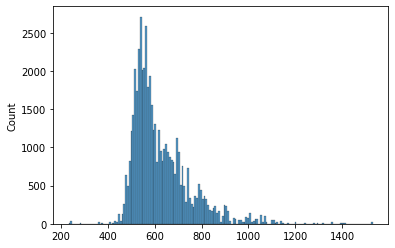

In [30]:
sns.histplot(x=trip_avg_stop_dists)

In [31]:
# The individual distances between every stops in every route
trip_stop_dists.explode().astype(float).describe()

count    2.199935e+06
mean     6.169178e+02
std      4.431542e+02
min      0.000000e+00
25%      3.772639e+02
50%      5.266410e+02
75%      7.303141e+02
max      2.761651e+04
dtype: float64

<AxesSubplot:>

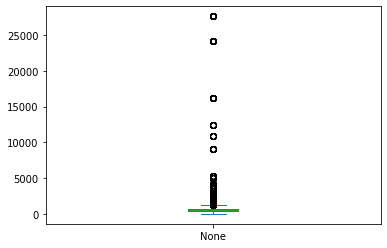

In [32]:
trip_stop_dists.explode().astype(float).plot.box()

In [33]:
trip_avg_stop_dists.sort_values(ascending=False)

trip_id
136_06_10    1531.839260
136_08_10    1531.839260
136_06_40    1531.839260
136_06_50    1531.839260
136_07_00    1531.839260
                ...     
310_21_40     232.317376
310_22_00     232.317376
310_22_10     232.317376
310_22_20     232.317376
310_20_20     232.317376
Length: 50355, dtype: float64

# Median bus speed

Removed because some stops don't have an associated stop time:

In [28]:
np.setdiff1d(stops.stop_id.unique(), stop_times.stop_id.unique())

array([1730, 1731, 2443, 2444, 3128, 3129, 3130, 3131, 3132, 3134, 3747,
       3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3832, 3833, 3834,
       3835, 3836, 3837, 3855, 3914, 3935, 3947, 3948, 3949, 3950, 4104,
       4143])

In [29]:
stop_times[stop_times.stop_id == 1730]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence


In [30]:
stops[stops.stop_id == 1730]

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id
1713,1730,DC4019,Dauralla Border,28.507925,76.896927,1730


# Number of links

# Number of nodes

# Network diameter

In [65]:
def f(x):
    df = x.sort_values('stop_sequence')
    # networkx refuses to take Points so we need to transform it back to floats
    def g(row):
        p = transformer(Point(row.stop_lon, row.stop_lat))
        return (p.x, p.y)
    points = df[['stop_lon', 'stop_lat']].apply(g,axis=1)
    # combine all stops into a single list for the single trip_id
    return points.reset_index(drop=True).to_list()

trip_stop_coords = stop_times_with_loc.groupby('trip_id').apply(f)
trip_stop_coords

trip_id
0_20_20    [(8581937.473719167, 3357553.47980293), (85822...
0_20_30    [(8581937.473719167, 3357553.47980293), (85822...
0_20_40    [(8581937.473719167, 3357553.47980293), (85822...
0_20_50    [(8581937.473719167, 3357553.47980293), (85822...
0_21_00    [(8581937.473719167, 3357553.47980293), (85822...
                                 ...                        
9_21_10    [(8591437.033785501, 3338474.1957936427), (859...
9_21_20    [(8591437.033785501, 3338474.1957936427), (859...
9_21_30    [(8591437.033785501, 3338474.1957936427), (859...
9_21_40    [(8591437.033785501, 3338474.1957936427), (859...
9_21_50    [(8591437.033785501, 3338474.1957936427), (859...
Length: 50355, dtype: object

In [66]:
trip_stop_coords_dict = trip_stop_coords.to_dict()

In [67]:
g = nx.from_dict_of_lists(trip_stop_coords_dict)

In [ ]:
#nx.algorithms.distance_measures.diameter(g)

# Network density

In [ ]:
#nx.classes.function.density(g)